# Exercise 6.6

## This script contains:
1. Import libraries & data
2. Data Wrangling
3. Line Graph of Monthly Attendance
4. Dickey-Fuller Test

### Import Libraries & Data

In [9]:
# Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [10]:
# Upload MLB Attendance 2009-2023 csv
mlbatt = pd.read_csv(r"C:\Users\cschw\OneDrive\Desktop\MLB Project\Data Sets\Other Data\Attendance 2009-2023.csv")

In [11]:
# Check head of df
mlbatt.head()

,Date,Attendance,Unnamed: 2,Unnamed: 3
0,20230330,36054.0,NaN,NaN
1,20230330,44063.0,NaN,NaN
2,20230330,52075.0,NaN,NaN
3,20230330,31397.0,NaN,NaN
4,20230330,45103.0,NaN,NaN


In [12]:
# Drop the unneccesary columns
mlbatt = mlbatt[['Date', 'Attendance']]


In [13]:
mlbatt.head()

,Date,Attendance
0,20230330,36054.0
1,20230330,44063.0
2,20230330,52075.0
3,20230330,31397.0
4,20230330,45103.0


### Data Wrangling

In [15]:
#Covert Data column to useable format
mlbatt['Date'] = pd.to_datetime(mlbatt['Date'], format='%Y%m%d')


In [16]:
# Check head
mlbatt.head()

,Date,Attendance
0,2023-03-30,36054.0
1,2023-03-30,44063.0
2,2023-03-30,52075.0
3,2023-03-30,31397.0
4,2023-03-30,45103.0


In [17]:
# Check for NaN values
mlbatt.isna().sum().sum()

4

In [18]:
# Show rows with NaN values
mlbatt[mlbatt.isna().any(axis=1)]


,Date,Attendance
1900,2023-08-23,NaN
2370,2023-09-27,NaN
2890,2022-05-11,NaN
18209,2015-04-29,NaN


In [28]:
# Fill NaN values in Attendance column with its average
mlbatt['Attendance'].fillna(mlbatt['Attendance'].mean(), inplace=True)


In [30]:
# Check again for NaN values
mlbatt.isna().sum().sum()

0

In [32]:
mlbatt.shape

(34914, 2)

In [34]:
# Set the 'date' column as the index
mlbatt.set_index('Date', inplace=True)


In [36]:
mlbatt.head()

,Attendance
Date,
2023-03-30,36054.0
2023-03-30,44063.0
2023-03-30,52075.0
2023-03-30,31397.0
2023-03-30,45103.0


In [38]:
# Group by month and sum the attendance figures
monthly_att = mlbatt.resample('M').sum()

In [40]:
monthly_att = monthly_att.asfreq('M')

In [43]:
monthly_att.head()

,Attendance
Date,
2009-04-30,9336422.0
2009-05-31,12692178.0
2009-06-30,11960647.0
2009-07-31,12684671.0
2009-08-31,13004341.0


### Plot line graph of monthly attendance

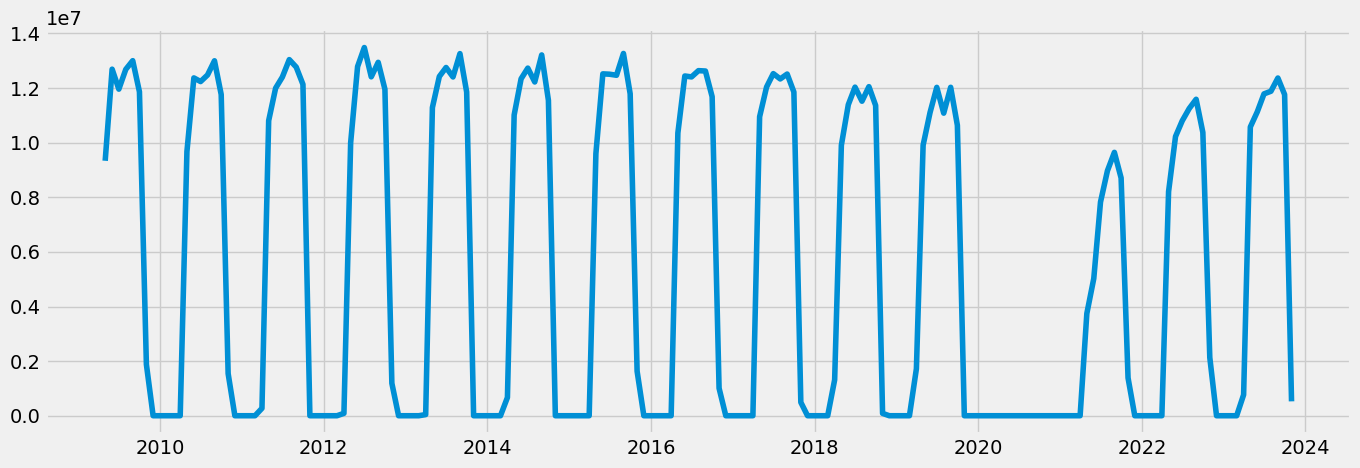

In [48]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(monthly_att)

### Decomposition

In [50]:
decomposition = sm.tsa.seasonal_decompose(monthly_att, model='additive')

In [52]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

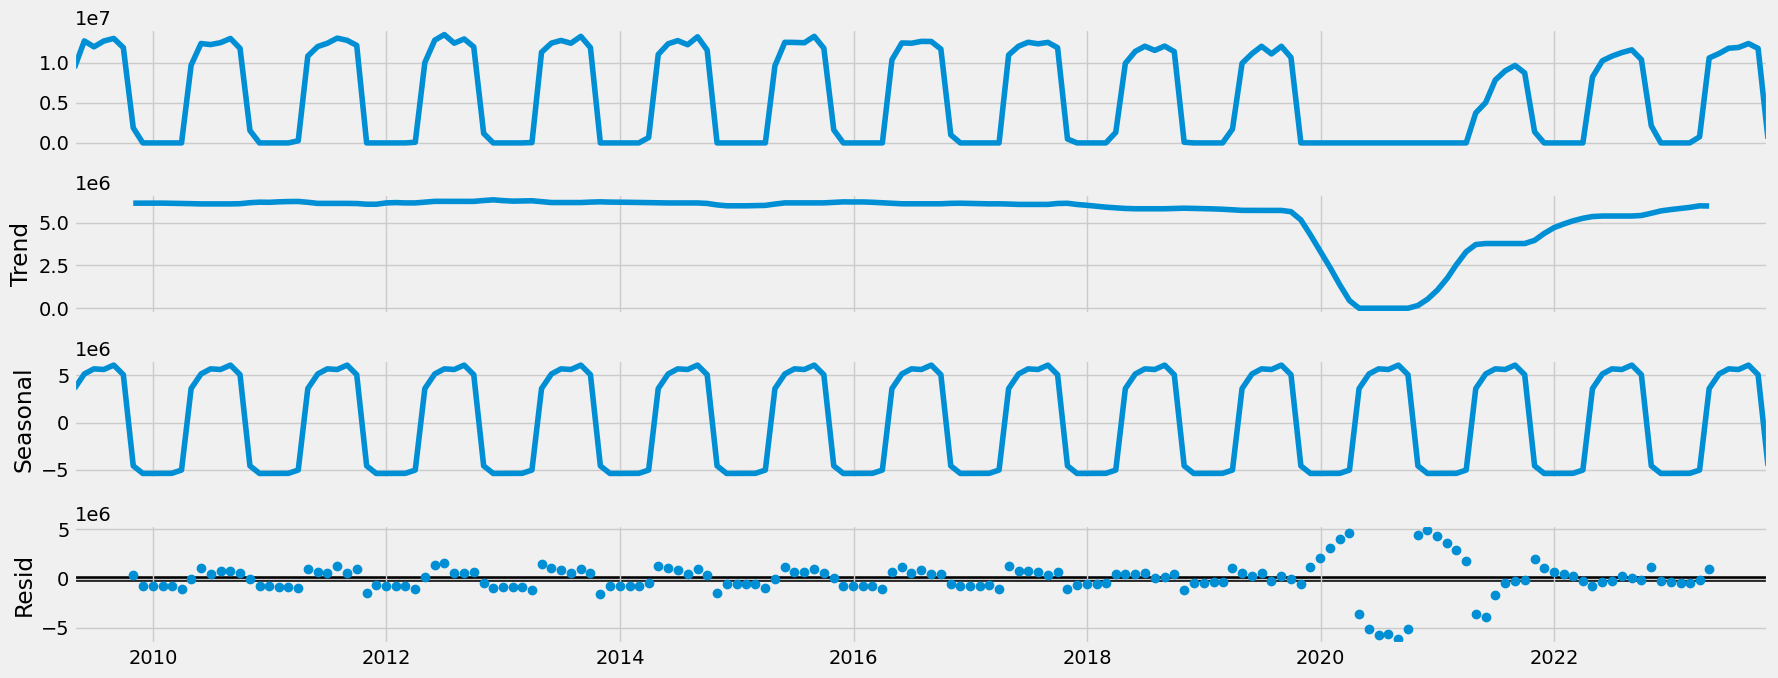

In [54]:
# Plot the separate components

decomposition.plot()
plt.show()

The trend line clearly shows the effect of the pandemic in 2020 and the recovery after words. The seasonality line shows that this data, as expected is clearly seasonal. The resid line shows that there isn't much noise except between 2020 and 2022, again during the pandemic. 

## Dickey Fuller Test

In [56]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_att['Attendance'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.585171
p-value                          0.096101
Number of Lags Used             12.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64


The data is close to being stationary but not quite, it needs one more round of transformation.

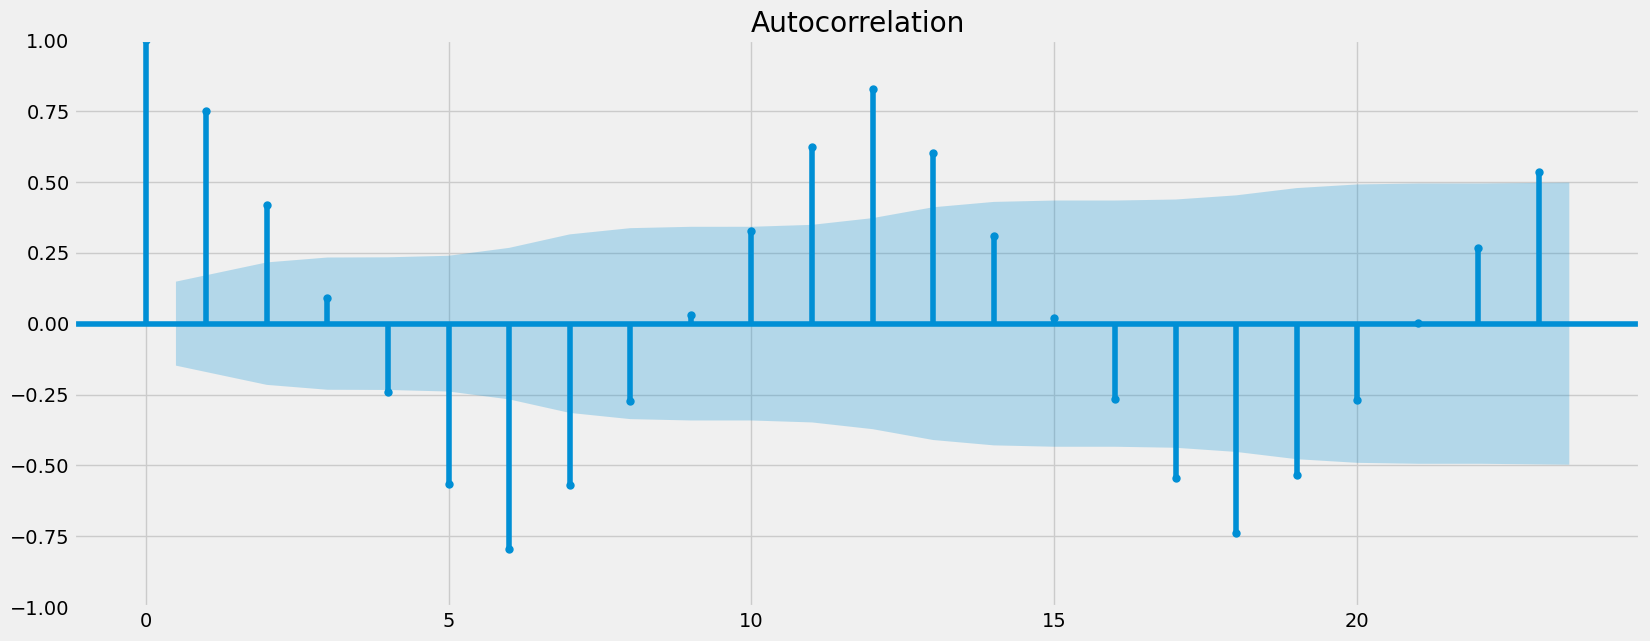

In [87]:
# Graph autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(monthly_att)
plt.show()

In [60]:
# Differencing
data_diff = monthly_att - monthly_att.shift(1)

In [79]:
# Remove missing values
data_diff.dropna(inplace = True) 

In [64]:
data_diff.head()

,Attendance
Date,
2009-05-31,3355756.0
2009-06-30,-731531.0
2009-07-31,724024.0
2009-08-31,319670.0
2009-09-30,-1141357.0


In [66]:
data_diff.columns

Index(['Attendance'], dtype='object')

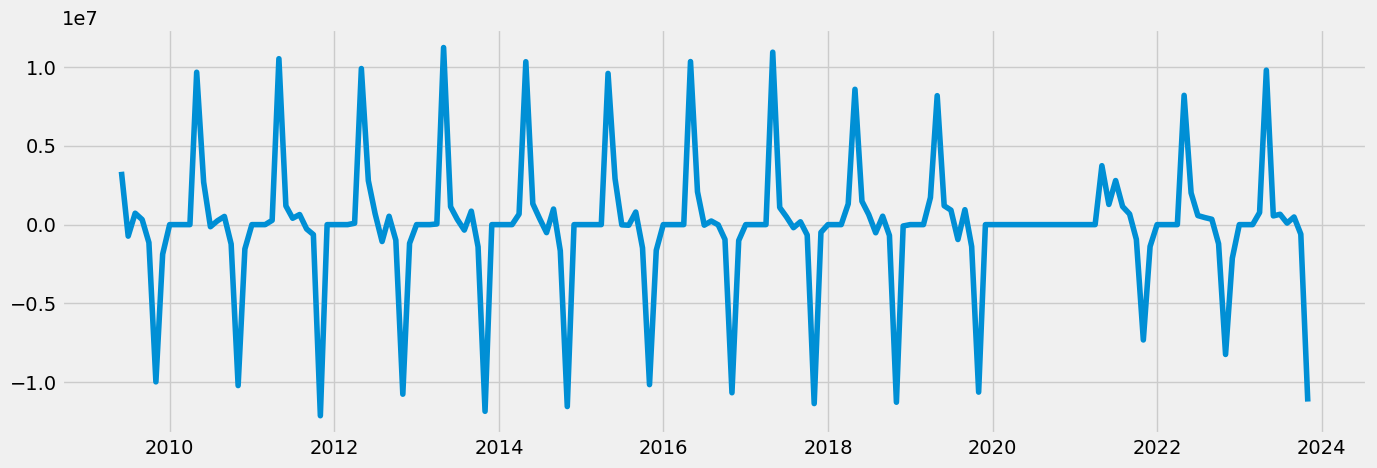

In [81]:
# Plot line graph

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [83]:
# Run dickey fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.317899
p-value                          0.000414
Number of Lags Used             11.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64


The test statistic is now loess than the critical value at each confidence level, and the p-value is much below .05. The data is now stationary. 

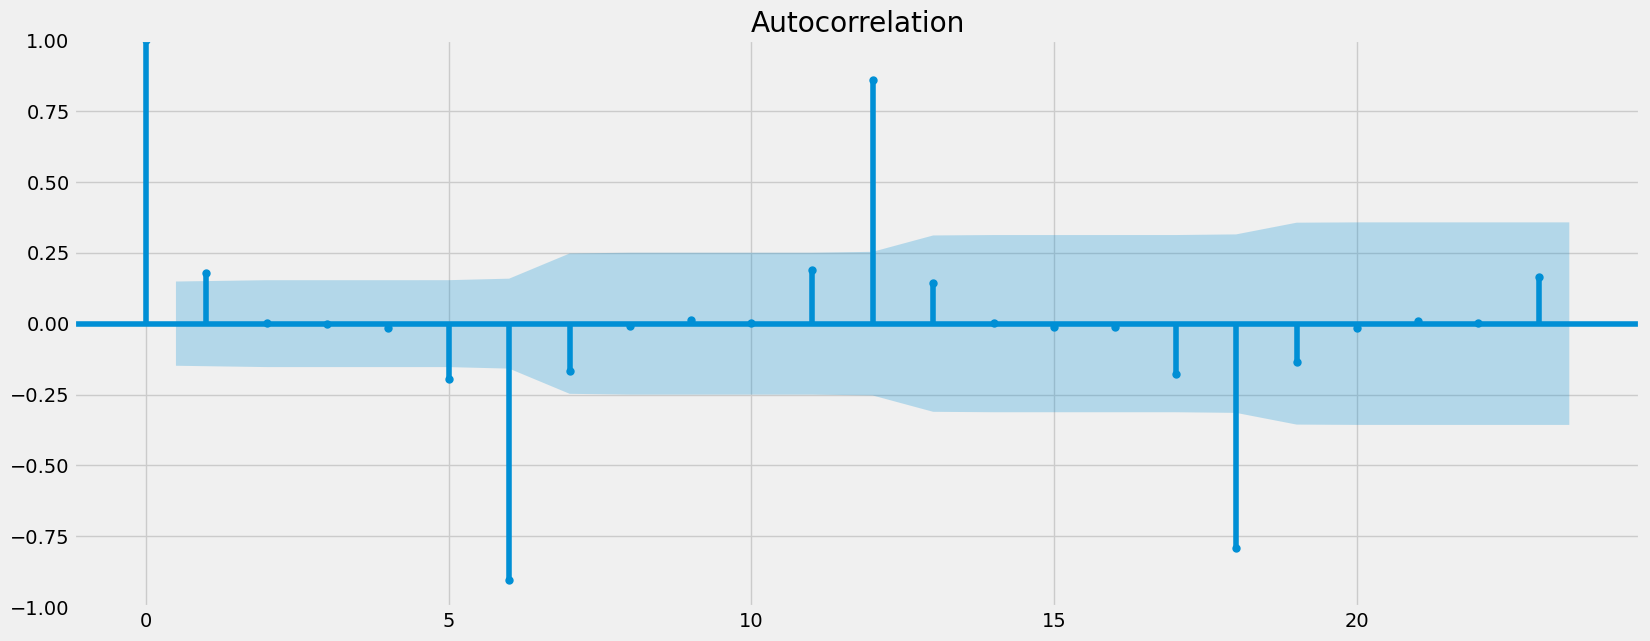

In [85]:
# Graph autocorrelation
plot_acf(data_diff)
plt.show()

### Repeat with only 2021-2024 data

In [95]:
# Reset index to turn 'Date' back into a regular column
monthly_att = monthly_att.reset_index()


In [97]:
# Convert 'Date' column to string and extract the year
monthly_att['Year'] = monthly_att['Date'].astype(str).str[:4].astype(int)

In [101]:
monthly_att.head()

,Date,Attendance,Year
0,2009-04-30,9336422.0,2009
1,2009-05-31,12692178.0,2009
2,2009-06-30,11960647.0,2009
3,2009-07-31,12684671.0,2009
4,2009-08-31,13004341.0,2009


In [99]:
# Filter rows for years 2021, 2022, 2023, and 2024
filtered_att = monthly_att[monthly_att['Year'].isin([2021, 2022, 2023, 2024])]

In [105]:
filtered_att.head()

,Date,Attendance,Year
141,2021-01-31,0.0,2021
142,2021-02-28,0.0,2021
143,2021-03-31,0.0,2021
144,2021-04-30,3742890.0,2021
145,2021-05-31,5024905.0,2021


In [107]:
# Drop the 'Year' column and reset the index if needed
filtered_att = filtered_att.drop(columns=['Year']).set_index('Date')

In [109]:
filtered_att.head()

,Attendance
Date,
2021-01-31,0.0
2021-02-28,0.0
2021-03-31,0.0
2021-04-30,3742890.0
2021-05-31,5024905.0


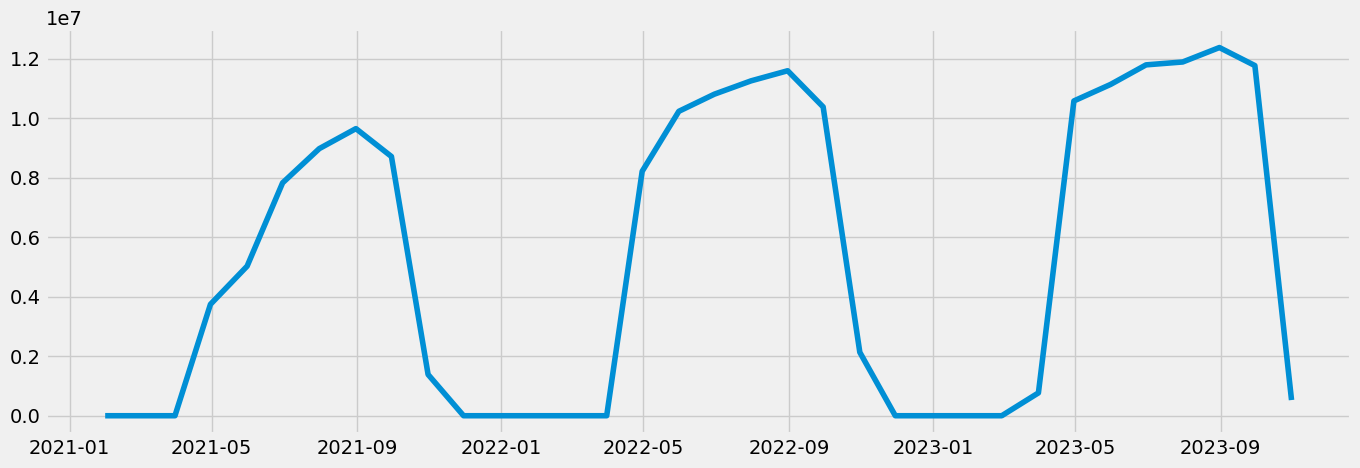

In [119]:
# Plot filtered attendance line graph
plt.figure(figsize=(15,5), dpi=100)
plt.plot(filtered_att)

In [117]:
# Define decomposition
decomposition = sm.tsa.seasonal_decompose(filtered_att, model='additive')

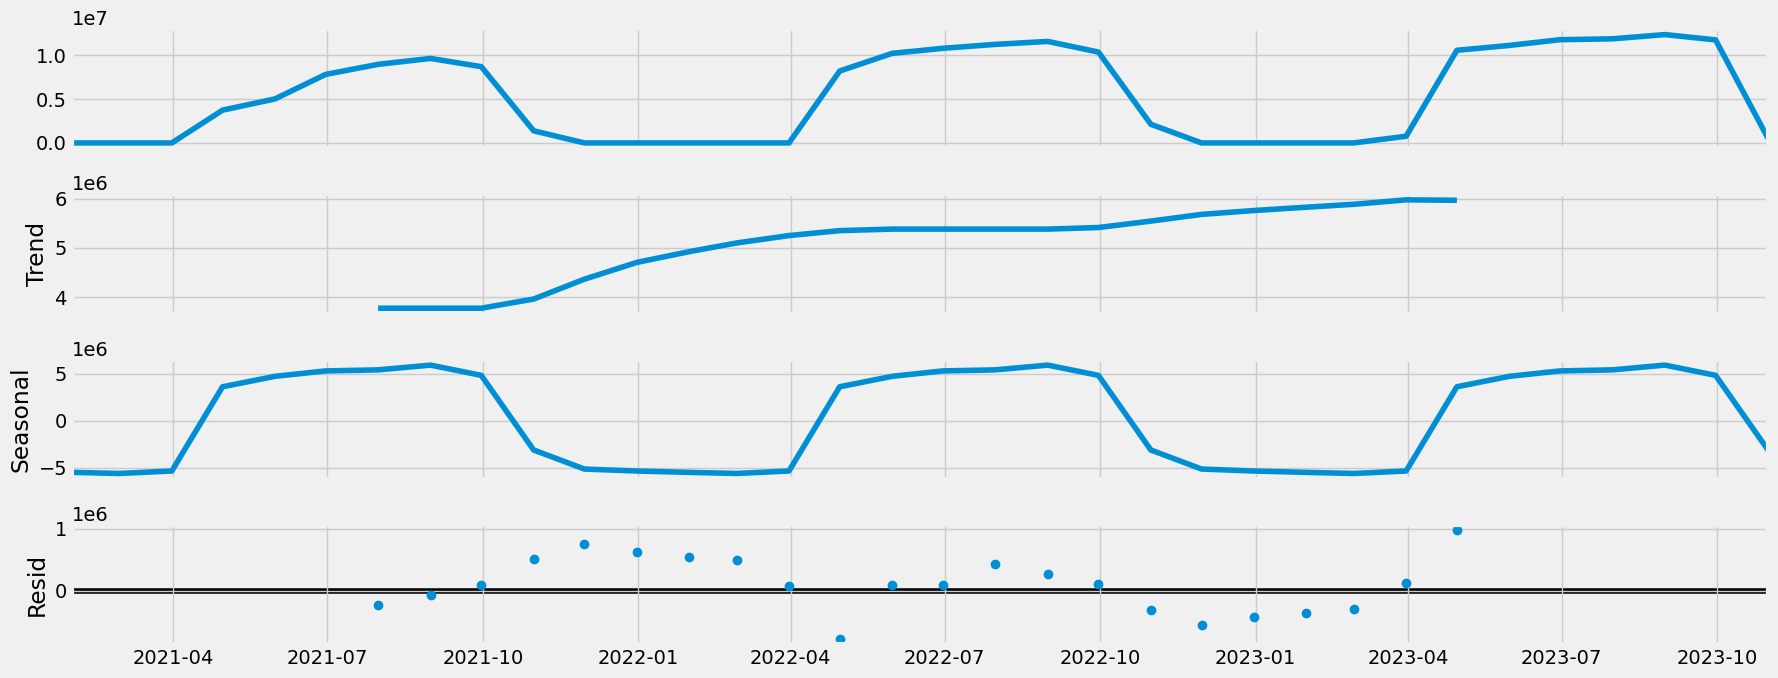

In [121]:
# Plot the separate components

decomposition.plot()
plt.show()

Here the trend line shows a steady recovery in attendance numbers since the pandemic ended. This is good news for MLB and further evidence that attendance is recovering. The seasonlity graph once again shows the nature of a sports season. If I could prevent python from including months with no games in the graph, this would be much more useful. There is more noise in this decompisition than the unfiltered one. 

In [124]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(filtered_att['Attendance'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.747809
p-value                         0.003489
Number of Lags Used            10.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


The test statistic is barely higher than the 1% critical level, but is lower than the 5% and 10%. The p-value is also below .05. So I would conclude this data is stationary. 

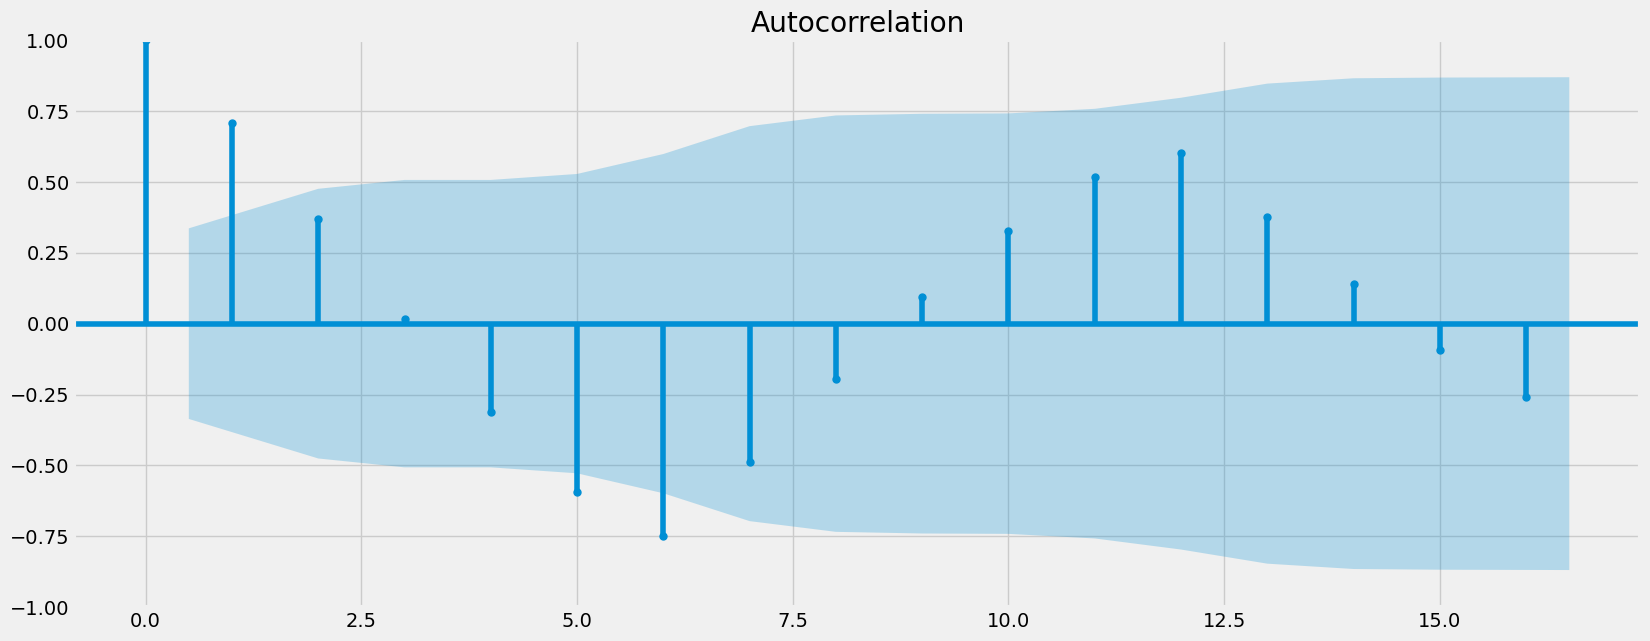

In [126]:
# Graph autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(filtered_att)
plt.show()